<a href="https://colab.research.google.com/github/nicole-victoria/image_classification/blob/main/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#importações
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt


In [4]:
# Carrega dados e metadados(cats_vs_dogs do TensorFlow)
splits = ["train[:80%]", "train[80%:90%]", "train[90%:100%]"] #define divisao dos dados para treinamento, teste e validação
train_ds, val_ds, test_ds = tfds.load("cats_vs_dogs",
                                       split=splits,
                                       as_supervised=True, #imagem, rótulo
                                       with_info=False)

In [5]:
IMG_SIZE = (150, 150) #definição da dimensao da imagem
BATCH_SIZE = 32 #definição de lotes de imagens

#pré-processamento da imagem
def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

#faz ajustes aleatórios nas imagens pro modelo "aprender" com mais eficiência
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image, label

# preparação do conjunto de treino
train_ds = (train_ds.map(preprocess)
                    .map(augment)
                    .shuffle(1000)
                    .batch(BATCH_SIZE)
                    .prefetch(tf.data.AUTOTUNE))

# preparação do conjunto de validação(augment nao foi utilizada augmentação, para focar na avaliação de imagens reais, sem distorções)
val_ds = (val_ds.map(preprocess)
                  .batch(BATCH_SIZE)
                  .prefetch(tf.data.AUTOTUNE))


In [6]:
#definição do modelo base com MobileNetV2(transfer learning)
base_model = tf.keras.applications.MobileNetV2(input_shape=(*IMG_SIZE, 3), #define o tamanho de entrada da imagem e canais de cor(3 ou RGB)
                                               include_top=False, # remove a parte final do modelo original, que fazia classificação de 1000 classes do ImageNet.
                                               weights="imagenet")

base_model.trainable = False #congela modelo base

#definição do modelo final(sequencial)
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(), #Reduz as saídas do base_model para um vetor pequeno.
    layers.Dense(1, activation="sigmoid") #definição da última camada com apenas 1 neurônio, para fazer a classificação binária
])


/tmp/ipython-input-2672189685.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=(*IMG_SIZE, 3), #define o tamanho de entrada da imagem e canais de cor(3 ou RGB)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
#compilação e treinamento do modelo

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(train_ds,
                    epochs=5,
                    validation_data=val_ds)

Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 368s 618ms/step - accuracy: 0.9063 - loss: 0.2206 - val_accuracy: 0.9609 - val_loss: 0.0997
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 360s 616ms/step - accuracy: 0.9649 - loss: 0.0900 - val_accuracy: 0.9643 - val_loss: 0.1010
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 381s 614ms/step - accuracy: 0.9637 - loss: 0.0848 - val_accuracy: 0.9656 - val_loss: 0.0910
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 384s 620ms/step - accuracy: 0.9688 - loss: 0.0793 - val_accuracy: 0.9652 - val_loss: 0.0927
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 357s 612ms/step - accuracy: 0.9700 - loss: 0.0773 - val_accuracy: 0.9652 - val_loss: 0.0904


In [8]:
#Fine-Tuning

base_model.trainable = True #descongela as últimas camadas
fine_tune_at = 100  #definição do ponto de corte das camadas

#congela apenas as camadas iniciais(até 100)
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

#recompilação
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss="binary_crossentropy",
              metrics=["accuracy"])

#treinamento com Fine Tuning
history_ft = model.fit(train_ds,
                       epochs=10,
                       validation_data=val_ds,
                       initial_epoch=history.epoch[-1]) #garante que O treinamento continue de onde parou

Epoch 5/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 658s 1s/step - accuracy: 0.8982 - loss: 0.2344 - val_accuracy: 0.9630 - val_loss: 0.1017
Epoch 6/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 647s 1s/step - accuracy: 0.9535 - loss: 0.1120 - val_accuracy: 0.9635 - val_loss: 0.0938
Epoch 7/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 622s 1s/step - accuracy: 0.9679 - loss: 0.0874 - val_accuracy: 0.9660 - val_loss: 0.0858
Epoch 8/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 599s 1s/step - accuracy: 0.9697 - loss: 0.0755 - val_accuracy: 0.9682 - val_loss: 0.0834
Epoch 9/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 603s 1s/step - accuracy: 0.9780 - loss: 0.0630 - val_accuracy: 0.9708 - val_loss: 0.0808
Epoch 10/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 604s 1s/step - accuracy: 0.9785 - loss: 0.0561 - val_accuracy: 0.9716 - val_loss: 0.0801


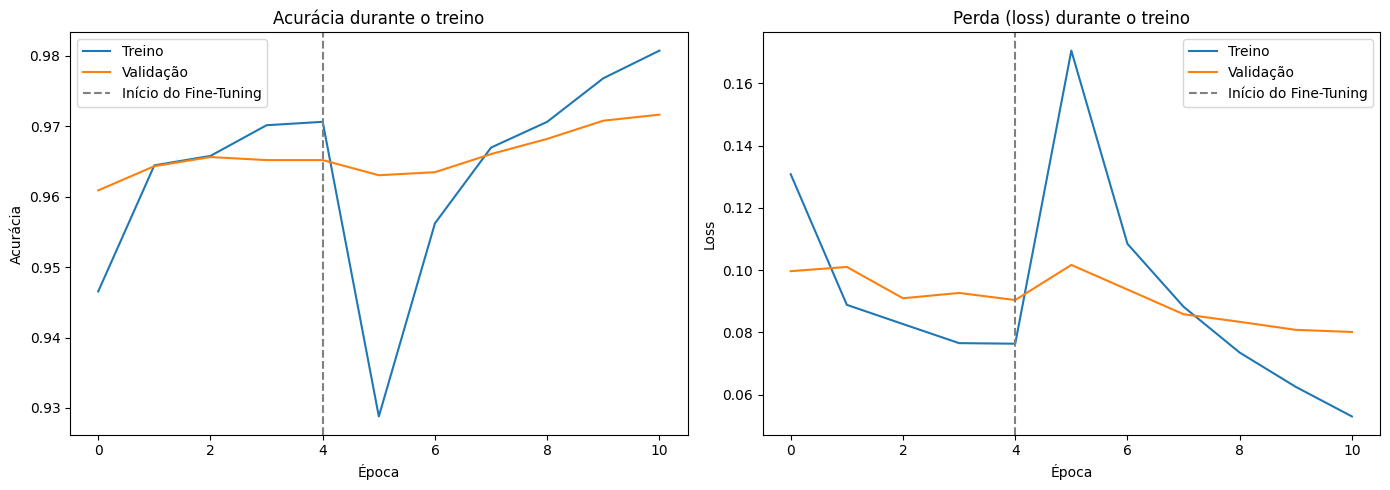

In [9]:
#Visualização dos resultados

# Junta os históricos anteriores
acc = history.history["accuracy"] + history_ft.history["accuracy"]
val_acc = history.history["val_accuracy"] + history_ft.history["val_accuracy"]

loss = history.history["loss"] + history_ft.history["loss"]
val_loss = history.history["val_loss"] + history_ft.history["val_loss"]

epochs_range = range(len(acc))

# Plotando
plt.figure(figsize=(14, 5))

# Acurácia
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Treino")
plt.plot(epochs_range, val_acc, label="Validação")
plt.axvline(x=history.epoch[-1], color="gray", linestyle="--", label="Início do Fine-Tuning")
plt.title("Acurácia durante o treino")
plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.legend()

# Perda
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Treino")
plt.plot(epochs_range, val_loss, label="Validação")
plt.axvline(x=history.epoch[-1], color="gray", linestyle="--", label="Início do Fine-Tuning")
plt.title("Perda (loss) durante o treino")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
# teste final com imagem que não usada no treinamento(imagem de cachorro)

# Carrega a imagem com o mesmo tamanho que usamos no treino
img = image.load_img("/content/dog.jpg", target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)

# Interpreta o resultado
class_names = ["Cat", "Dog"]
predicted_class = class_names[int(prediction[0] > 0.5)] #calcular probabilidade de ser Cachorro, ou seja, valor perto de 1

print(f"Predição: {predicted_class} (score = {prediction[0][0]:.4f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predição: Dog (score = 0.9982)


/tmp/ipython-input-2238242226.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_names[int(prediction[0] > 0.5)] #calcular probabilidade de ser Cachorro, ou seja, valor perto de 1


In [15]:
# teste final com imagem que não usada no treinamento(imagem de gato)

# Carrega a imagem com o mesmo tamanho que usamos no treino
img = image.load_img("/content/cat.jpg", target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)

# Interpreta o resultado
class_names = ["Cat", "Dog"]
predicted_class = class_names[int(prediction[0] > 0.5)] #calcular probabilidade de ser Cachorro, ou seja, valor perto de 1

print(f"Predição: {predicted_class} (score = {prediction[0][0]:.4f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Predição: Cat (score = 0.0021)


/tmp/ipython-input-2043639845.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_names[int(prediction[0] > 0.5)] #calcular probabilidade de ser Cachorro, ou seja, valor perto de 1
